## Libraries

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch 
import torch.nn as nn
from torch.nn import Conv2d, BatchNorm2d, MaxPool2d, AvgPool2d, Linear, CrossEntropyLoss, BCEWithLogitsLoss
from torch.nn.functional import leaky_relu
from torch.optim import Adamax
from torchvision.transforms import Compose, ToPILImage, Pad, RandomHorizontalFlip, RandomVerticalFlip, RandomRotation, ToTensor, Normalize
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

## Display data

In [2]:
train_df = pd.read_csv("./input/train_labels.csv")

train_df.head(10)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
5,acfe80838488fae3c89bd21ade75be5c34e66be7,0
6,a24ce148f6ffa7ef8eefb4efb12ebffe8dd700da,1
7,7f6ccae485af121e0b6ee733022e226ee6b0c65f,1
8,559e55a64c9ba828f700e948f6886f4cea919261,0
9,8eaaa7a400aa79d36c2440a4aa101cc14256cda4,0


In [3]:
train, val = train_test_split(
        train_df,
        stratify = train_df["label"],
        shuffle = True,
        test_size = 0.1
)

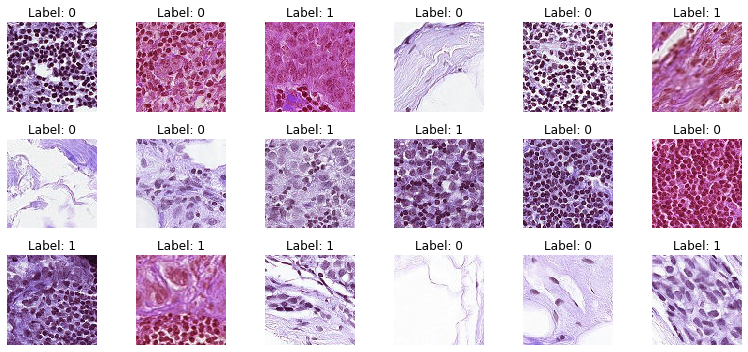

In [8]:
random_img_ids = np.random.choice(train_df["id"], 18)

fig = plt.figure(figsize = (11, 5))
for i, img_id in enumerate(random_img_ids):
    plt.subplot(3, 6, i + 1)
    img = cv2.imread("./input/train/" + img_id + ".tif")
    label = train_df["label"].loc[train_df["id"] == img_id].values[0]
    plt.imshow(img)
    plt.title(f"Label: {label}")
    plt.axis("off")
plt.tight_layout() 

## Data generator

In [5]:
class CancerDataset(Dataset):    
    def __init__(self, df_data, path, augmentations = None):
        self.df = df_data.values
        self.path = path
        self.augmentations = augmentations

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_id, label = self.df[index]
        img = cv2.imread(self.path + img_id + ".tif")
        
        if self.augmentations is not None:
            img = self.augmentations(img)
            
        return img, label

augs_train = Compose([
        ToPILImage(),
        Pad(64, padding_mode = "reflect"),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        RandomRotation(20),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

augs_val = Compose([
        ToPILImage(),
        Pad(64, padding_mode = "reflect"),
        ToTensor(),
        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset_train = CancerDataset(train, "./input/train/", augmentations = augs_train)
dataset_val = CancerDataset(val, "./input/train/",  augmentations = augs_val)

batch_size = 128

train_gen = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)
val_gen = DataLoader(dataset_val, batch_size = batch_size // 2, shuffle = False)

## Specify model

In [6]:
class SimpleCNN(nn.Module): 
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = Conv2d(3, 32, 3, padding = 2)
        self.conv2 = Conv2d(32, 64, 3, padding = 2)
        self.conv3 = Conv2d(64, 128, 3, padding = 2)
        self.conv4 = Conv2d(128, 256, 3, padding = 2)
        self.conv5 = Conv2d(256, 512, 3, padding = 2)
        self.bn1 = BatchNorm2d(32)
        self.bn2 = BatchNorm2d(64)
        self.bn3 = BatchNorm2d(128)
        self.bn4 = BatchNorm2d(256)
        self.bn5 = BatchNorm2d(512)
        self.pool = MaxPool2d(2, stride = 2)
        self.avg = AvgPool2d(8)
        self.fc = Linear(512*1*1, 2)
        
    def forward(self, x):
        x = self.pool(leaky_relu(self.bn1(self.conv1(x))))
        x = self.pool(leaky_relu(self.bn2(self.conv2(x))))
        x = self.pool(leaky_relu(self.bn3(self.conv3(x))))
        x = self.pool(leaky_relu(self.bn4(self.conv4(x))))
        x = self.pool(leaky_relu(self.bn5(self.conv5(x))))
        x = self.avg(x)
        x = x.view(-1, 512*1*1) # flatten
        x = self.fc(x)
        return x

model = SimpleCNN().cuda()

criterion = CrossEntropyLoss() #BCEWithLogitsLoss() # sigmoid activation + BCE loss
optimizer = Adamax(model.parameters(), lr = 2e-3, betas = (0.9, 0.999))

## Fit model

In [7]:
num_epochs = 7 

for epoch_i in range(num_epochs):
    model.train() # set train mode
    train_loss = []
    val_loss = []
    
    for batch_i, (images, labels) in enumerate((train_gen)):
        images = images.cuda()
        labels = labels.cuda()
        optimizer.zero_grad() # clear gradients        
        output = model(images)
        loss = criterion(output, labels)
        train_loss.append(loss.item())        
        loss.backward() # compute gradient
        optimizer.step() # update parameters
        
    # ------------- Evaluation on validation data -------------
    model.eval() # set evaluation mode
    with torch.no_grad():
        for batch_i, (images, labels) in enumerate(val_gen):
            images = images.cuda()
            labels = labels.cuda()
            output = model(images)
            loss = criterion(output, labels)
            val_loss.append(loss.item()) 

    print(f"Epoch {epoch_i + 1}/{num_epochs}, train loss: {np.mean(train_loss):.4f}, valid loss: {np.mean(val_loss):.4f}")

Epoch 1/7, train loss: 0.3472, valid loss: 0.2682
Epoch 2/7, train loss: 0.2373, valid loss: 0.2422
Epoch 3/7, train loss: 0.1929, valid loss: 0.2059
Epoch 4/7, train loss: 0.1734, valid loss: 0.2012
Epoch 5/7, train loss: 0.1587, valid loss: 0.1589
Epoch 6/7, train loss: 0.1488, valid loss: 0.1792
Epoch 7/7, train loss: 0.1406, valid loss: 0.1471


## Prediction

In [12]:
test_df = pd.read_csv("./input/sample_submission.csv")

dataset_test = CancerDataset(test_df, "./input/test/", augmentations = augs_val)
test_gen = DataLoader(dataset_test, batch_size = 32, shuffle = False)

model.eval()

preds = []

with torch.no_grad():
    for batch_i, (images, labels) in enumerate(test_gen):
        images = images.cuda()
        labels = labels.cuda()
        output = model(images)
        preds_batch = output[:, 1].cpu().numpy() # copy to host memory, convert to numpy
        preds.extend(preds_batch)
        
test_df["label"] = preds

test_df.to_csv("submission.csv", index = False)

test_df.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0.093509
1,95596b92e5066c5c52466c90b69ff089b39f2737,0.418916
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0.013294
3,2c35657e312966e9294eac6841726ff3a748febf,0.032007
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0.067520
